# Ensemble Model (csv_v2)

In [1]:
#importing the required libraries libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import numpy as np
import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
import logging

# importing boto3
from botocore.exceptions import ClientError

def initialize_s3_container(storage_name, locality=None):
    try:
        # if no locality is provided, use default aws region and create s3 client
        if locality is None:
            s3_service = boto3.client("s3")
            s3_service.create_bucket(Bucket=storage_name)
        else:
            s3_service = boto3.client("s3", region_name=locality)
            config_location = {"LocationConstraint": locality}
            s3_service.create_bucket(
                Bucket=storage_name, CreateBucketConfiguration=config_location
            )

    except ClientError as error_log:
        logging.error(error_log)
        return False
    #printing the message after successful creation
    print(f"S3 Bucket: {storage_name} has been successfully created.")
    return True

## Bucket Verification

In [3]:
#function to check if the bucket exists
def bucket_check(bucket_name):
    s3 = boto3.client("s3")
    try:
        #checking if the bucket exists using head_bucket
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        #handling the 404 error if the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            #raising any other error if it occurs
            raise

## Bucket setup

In [4]:
## setting the s3 bucket name, fetching the s3 resource, checking if the bucket exists, and creating it if not
bucket_dsts = "u3268702-dsts-rohit-ensemble-1"
s3_instance = boto3.Session().resource("s3")
container_exists = bucket_check(bucket_dsts)
if not container_exists:
    initialize_s3_container(bucket_dsts)

Bucket 'u3268702-dsts-rohit-ensemble-1' does not exist.
S3 Bucket: u3268702-dsts-rohit-ensemble-1 has been successfully created.


In [5]:
# setting the prefix and defining a function to upload a csv file to aws s3

prefix = "oncloud"

def upload_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_instance.Bucket(bucket_dsts))
    s3_instance.Bucket(bucket_dsts).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

### Reading the data

In [6]:
#loading the data
df_v1 = pd.read_csv("./combined_csv_v2.csv")

print(df_v1.head())
print(df_v1.shape)

   target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0     689.0            21      33       0    54.0      30       0   
1     0.0     731.0             9      39       0   136.0      33       0   
2     0.0    1199.0            18      33       0    54.0      77       0   
3     0.0    1587.0            16      33       0    54.0      20       0   
4     0.0    1587.0             7      20       0   165.0      33       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   130.0     0.0  ...       False     False     False     False      True   
1    54.0     0.0  ...       False     False     False     False     False   
2    68.0     0.0  ...       False     False      True     False     False   
3   165.0     0.0  ...       False     False     False     False     False   
4    54.0     0.0  ...       False     False     False     False     False   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
0     Fals

In [7]:
#creating the copy of the original data
df=df_v1.copy()

In [9]:
#converting all boolean values to 1 and 0
df = df.replace({True: 1, False: 0})

In [10]:
df.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#checking the null values
df.isnull().sum()

target          0
Distance        0
DepHourofDay    0
AWND_O          0
PRCP_O          0
               ..
Dest_LAX        0
Dest_ORD        0
Dest_PHX        0
Dest_SFO        0
is_holiday_1    0
Length: 86, dtype: int64

### Split the dataset

In [12]:
#spliting the dataset into train, test and validation (70,15,15)
train, test_and_validate = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [13]:
#printing the shape
print(train.shape)
print(test.shape)
print(validate.shape)

(1144913, 86)
(245338, 86)
(245339, 86)


In [14]:
#changing the names for the files to upload to the bucket
train_file = "data_v1_train.csv"
test_file = "data_v1_test.csv"
validate_file = "data_v1_validate.csv"

In [15]:
#uploading each dataset subset to the specified S3 locations
upload_csv(train_file, "train", train)
upload_csv(test_file, "test", test)
upload_csv(validate_file, "validate", validate)

s3.Bucket(name='u3268702-dsts-rohit-ensemble-1')
s3.Bucket(name='u3268702-dsts-rohit-ensemble-1')
s3.Bucket(name='u3268702-dsts-rohit-ensemble-1')


In [16]:
#retrieving the amazon sagemaker container for the 'linear-learner' in the 'us-east-1' region
container = retrieve("xgboost", "us-east-1", version="1.0-1")

In [17]:
#defining paramters
params={"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

In [18]:
# setting up the sagemaker session, output location, and xgboost model with paramters which we defined

session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))
s3_output_location = "s3://{}/{}/output/".format(bucket_dsts, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    output_path=s3_output_location,
    hyperparameters=params,
    sagemaker_session=session,
)


In [19]:
# setting up the training and validation input channels from s3, specifying content type as csv
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(bucket_dsts, prefix, train_file), content_type="text/csv"
)

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(bucket_dsts, prefix, validate_file), content_type="text/csv"
)

print(f"channels {validate_channel} \n {train_channel}")

data_channels = {"train": train_channel, "validation": validate_channel}


channels <sagemaker.inputs.TrainingInput object at 0x7fdb8f156dd0> 


## Train the model

In [20]:
#fitting the model
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-04-10-58-32-815



2024-11-04 10:58:35 Starting - Starting the training job..
2024-11-04 10:58:50 Starting - Preparing the instances for training.....
2024-11-04 10:59:21 Downloading - Downloading input data....
2024-11-04 10:59:46 Downloading - Downloading the training image...
2024-11-04 11:00:07 Training - Training image download completed. Training in progress............
2024-11-04 11:01:07 Uploading - Uploading generated training model.
2024-11-04 11:01:16 Completed - Training job completed


In [21]:
# deploying the trained xgboost model to an endpoint with specified instance settings and csv serializer
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.4xlarge",
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-04-11-01-28-996
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-04-11-01-28-996
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-04-11-01-28-996


------!

## Batch Data for Prediction

In [22]:
#preparing the input data for batch prediction by extracting all columns except the first one from the test set which is our target variable
batch_input_data = test.iloc[:, 1:]
batch_input_filename = "batch-for-ensemble.csv"

#uploading the prepared csv file to s3
upload_csv(batch_input_filename, "batch-in", batch_input_data)

s3.Bucket(name='u3268702-dsts-rohit-ensemble-1')


In [23]:
#setting up the s3 locations for batch input and output, and creating a transformer from the xgboost model with specified parameters

batch_output = "s3://{}/{}/batch-out/".format(bucket_dsts, prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket_dsts, prefix, batch_input_filename)

xgboost_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-04-11-05-18-862


In [24]:
#starting the batch transform job with input data and waiting for it to complete

xgboost_transformer.transform(
    data=batch_input, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

xgboost_transformer.wait()


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-04-11-05-29-079


...................................[2024-11-04:11:11:15:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-04:11:11:15:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-04:11:11:15:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-04 11:11:15 +0000] [27] [INFO] Starting 

### Retrieving

In [25]:
#initializing the s3 client, retrieving the batch output file from s3, and reading it into a dataframe

s3 = boto3.client("s3")
obj = s3.get_object(
    Bucket=bucket_dsts, Key="{}/batch-out/{}".format(prefix, "batch-for-ensemble.csv.out")
)

target_predicted = pd.read_csv(io.BytesIO(obj["Body"].read()), names=["class"])


In [26]:
#function to convert predicted values to binary based on a threshold of 0.3
#if the value is greater than 0.3, it is classified as 1 (positive class)
#otherwise, it is classified as 0 (negative class)
def convert_to_binary(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

#applying the binary conversion to the "class" column of the predictions
#this step transforms continuous or probability predictions into binary values (0 or 1)
target_predicted_binary = target_predicted["class"].apply(convert_to_binary)



In [27]:
print(target_predicted_binary.head())

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


In [28]:
#extracting the test labels
test_labels_actual = test.iloc[:, 0]

test_labels_actual.head(5)

470151     0.0
985696     0.0
394886     0.0
924542     0.0
1533313    0.0
Name: target, dtype: float64

## Results

### Confusin Matrix

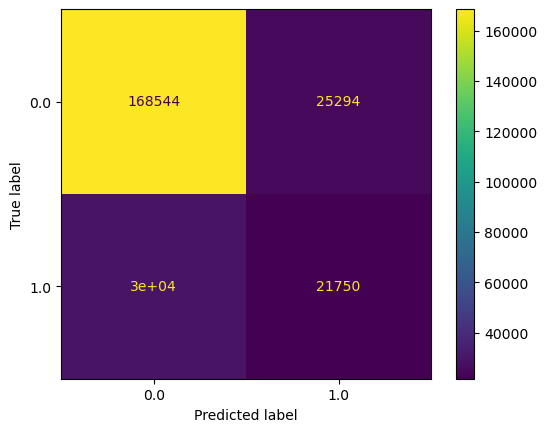

In [30]:
#plotting the confusion matrix
ConfusionMatrixDisplay.from_predictions(test_labels_actual, target_predicted_binary, cmap='viridis')
plt.show()

### Classification Report

In [31]:
#classification report
print("Classification Report on Test Data")
print(classification_report(test_labels_actual, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86    193838
         1.0       0.46      0.42      0.44     51500

    accuracy                           0.78    245338
   macro avg       0.66      0.65      0.65    245338
weighted avg       0.77      0.78      0.77    245338



**Model Comparison**
CSV v1 Model

- Class 0 (Non-Delayed Flights):
    - Precision: 0.83 — 83% of flights predicted as non-delayed were correctly identified.
    - Recall: 0.88 — 88% of actual non-delayed flights were correctly detected by the model.
    - F1-Score: 0.85 — A good balance between precision and recall for non-delayed flights.

Class 1 (Delayed Flights):
    - Precision: 0.40 — Only 40% of flights predicted as delayed were actually delayed.
    - Recall: 0.30 — The model only captured 30% of actual delayed flights, missing many true delayed cases.
    - F1-Score: 0.34 — Low overall effectiveness in identifying delayed flights.

Overall Accuracy: 0.76 — The model correctly classifies 76% of all flights, but performance on delayed flights is poor.

CSV v2 Model (Right)

- Class 0 (Non-Delayed Flights):
    - Precision: 0.85 — 85% of flights predicted as non-delayed were correctly classified.
    - Recall: 0.87 — The model correctly identified 87% of actual non-delayed flights.
    - F1-Score: 0.86 — Slightly better balance than CSV v1 for non-delayed flights.

Class 1 (Delayed Flights):
    - Precision: 0.46 — 46% of flights predicted as delayed were accurate, an improvement from CSV v1.
    - Recall: 0.42 — The model captured 42% of actual delayed flights, significantly better than CSV v1.
    - F1-Score: 0.44 — Improved ability to identify delayed flights, with a more balanced performance.

Overall Accuracy: 0.78 — The model has a higher overall accuracy, correctly classifying 78% of all flights.

Conclusion
The CSV v2 Model shows notable improvements, especially in detecting delayed flights. It has higher precision and recall for class 1, meaning it better identifies true delayed flights and makes fewer false predictions compared to CSV v1. The improvement in recall for delayed flights (Class 1) in the CSV v2 Model can be attributed to the inclusion of weather dataset features. These additional features provided more context and valuable information for the model to make better predictions about flight delays. As a result, the ensemble model's performance improved, particularly in identifying delayed flights, which is critical for applications that depend on accurate delay predictions.
